In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import inv
from subprocess import call
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    pathStatData = extSSDpath + getProjectFoldername() + '/stationary_distributions/data'
    if not os.path.exists(pathStatData):
        print('No SSD!!!!')

In [47]:
def gaussian(x,mean,var):
    return 1/(np.sqrt(2*np.pi*var)) * np.exp(-(x-mean)**2 / (2*var))

def jacobian(pis,qs,l,fsSol):
    k = len(pis)
    jac = np.empty([k,k])
    for i in range(k):
        for j in range(k):
            jac[i,j] = -((1-l)*pis[i]+l*fsSol[i+1])
            if i == j:
                jac[i,j] += (l*fsSol[0] - 1/qs[i])
    return jac

def GammaDiag(pis,qs,l,fsSol):
    k = len(pis)
    Gamma = np.empty(k)
    for i in range(k):
        Gamma[i] = fsSol[0]*((1-l)*pis[0] + l*fsSol[i]) + fsSol[i]/qs[i]
    return Gamma

def LambdaMat_eqs_keq2(t, Lambda, jac, Gamma):
    dLambdadt = []
    # Lambda_11
    L11 = 2*jac[0,0]*Lambda[0] + 2*jac[0,1]*Lambda[1] + Gamma[0]
    # Lambda_12 (=Lambda_21)
    L12 = jac[1,0]*Lambda[0] + (jac[0,0] + jac[1,1])*Lambda[1] + jac[0,1]*Lambda[2]
    # Lambda_22
    L22 = 2*jac[1,0]*Lambda[1] + 2*jac[1,1]*Lambda[2] + Gamma[1]
    dLambdadt = [L11, L12, L22]
    return dLambdadt

In [195]:
pis, qs, l = [0.1, 0.1], [9.0, 10.0], 0.7
N = 50

call(f'python3 f0poly_sols_clean.py {pis[0]} {pis[1]} {qs[0]} {qs[1]} {l} > sols.dat', shell=True)
with open('sols.dat', 'r') as file:
    fsSol = [float(f) for f in file.readline().split()]
jac = jacobian(pis, qs, l, fsSol)
Gamma = GammaDiag(pis, qs, l, fsSol)

Lambda0 = [0.33, 0.33, 0.33] # no se...
Lambda_int = solve_ivp(LambdaMat_eqs_keq2, [0,1000], Lambda0, args = (jac, Gamma))
Lambda_fxp = [Lambda_int.y[i,-1] for i in range(len(Lambda_int.y[:,-1]))]

In [ ]:
#check stat point has been reached
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(Lambda_int.t, Lambda_int.y[i])

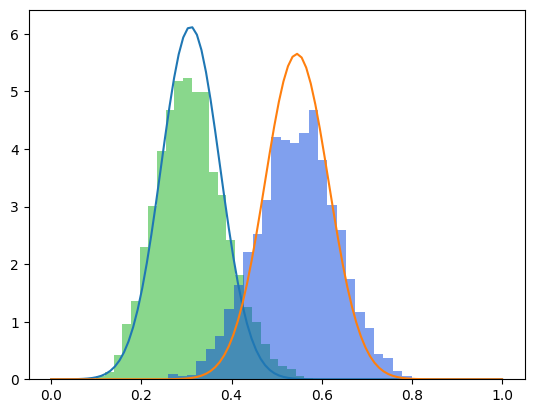

In [52]:
fig, ax = plt.subplots()

N = 50
bins_N = {2500:20, 1000:15, 500:15, 250:16, 100:18, 50:27}
plotSimData = True
if plotSimData:
    data = pd.read_csv(f'{pathStatData}/stat_data_N_{N}_pi1_{pis[0]}_pi2_{pis[1]}_q1_{qs[0]}_q2_{qs[1]}_l_{l}.csv')
    ax.hist(data['f1'], bins=bins_N[N]-1, density=True, rwidth=1.0, color='xkcd:green', histtype='stepfilled', alpha=0.5)
    ax.hist(data['f2'], bins=bins_N[N], density=True, rwidth=1.0, color='xkcd:blue', histtype='stepfilled', alpha=0.5, label=f'{N}')

plotVKaprox = True
if plotVKaprox:
    x = np.linspace(0,1,100)
    distr_site1 = gaussian(x, fsSol[1], Lambda_fxp[0]/N)
    distr_site2 = gaussian(x, fsSol[2], Lambda_fxp[2]/N)
    ax.plot(x, distr_site1)
    ax.plot(x, distr_site2)

In [196]:
LambdaMat = np.array([[Lambda_fxp[0], Lambda_fxp[1]], [Lambda_fxp[1], Lambda_fxp[2]]])
LambdaMat = LambdaMat /N # no seeeee
LambdaMat_inv = inv(LambdaMat)

In [198]:
# get who has the larger integer part:
maxIntPart, id = round(fsSol[0]*N,2)-int(fsSol[0]*N), 0
for i in range(1,3):
    intPart = round(fsSol[i]*N,2)-int(fsSol[i]*N)
    if intPart > maxIntPart:
        maxIntPart = intPart
        id = i

fsSolN_dec = [round(f*N,2) for f in fsSol]
fsSolN = [int(f*N) for f in fsSol]
if sum(fsSolN) < N:
    fsSolN[id] += 1

if sum(fsSolN) != N:
    print('still problems')
print(fsSolN_dec)
print(fsSolN)

# fsSolN = [round(fsSol[i]*N) for i in range(len(fsSol))]
# if sum(fsSolN) != N:
#     print('still problems')

still problems
[6.69, 11.52, 31.79]
[6, 11, 32]


In [199]:
fsSolN[2] += 1

In [200]:
# xiNmax = int(N*0.2)
xiNmax = N-max(fsSolN)

# old simple
# xgrid, ygrid = np.mgrid[-xiNmax:xiNmax:complex(0,xiNmax*2+1), -xiNmax:xiNmax:complex(0,xiNmax*2+1)]
# probGrid = np.zeros([2*xiNmax+1, 2*xiNmax+1])
# for i,x in enumerate(xgrid[:,0]):
#     for j,y in enumerate(ygrid[0,:]):
#         xivec = [x/N, y/N]
#         sumExp = 0
#         for alpha in range(2):
#             for beta in range(2):
#                 sumExp += xivec[alpha]*xivec[beta]*LambdaMat_inv[alpha, beta]
#         probGrid[i,j] = np.exp(-0.5*sumExp)

ax, bx = -fsSolN[1], N-fsSolN[1]
Nx = (bx-ax)+1
ay, by = -fsSolN[2], N-fsSolN[2]
Ny = (by-ay)+1

xgrid, ygrid = np.mgrid[ax:bx:complex(0,Nx), ay:by:complex(0,Ny)]
probGrid = np.zeros([Nx, Ny])
sum1win, sum2win = 0, 0
for i,x in enumerate(xgrid[:,0]):
    for j,y in enumerate(ygrid[0,:]):
        # fsFluc = [0, fsSolN[1]+x, fsSolN[2]+y]
        fsFluc = [fsSolN[1]+x, fsSolN[2]+y]
        # print(fsFluc, sum(fsFluc) <= N)
        if sum(fsFluc) <= N:
            xivec = [x/N, y/N]
            sumExp = 0
            for alpha in range(2):
                for beta in range(2):
                    sumExp += xivec[alpha]*xivec[beta]*LambdaMat_inv[alpha, beta]
            probGrid[i,j] = np.exp(-0.5*sumExp)
            if fsFluc[0] > fsFluc[1]:
                sum1win += probGrid[i,j]
            else:
                sum2win += probGrid[i,j]
        else:
            probGrid[i,j] = float('nan')

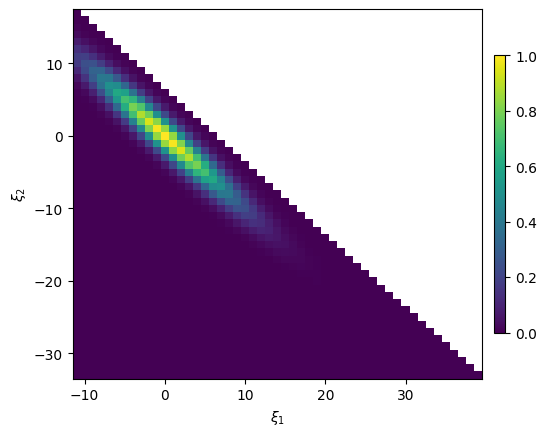

In [201]:
fig, ax = plt.subplots()
ax.set(xlabel=r'$\xi_1$', ylabel=r'$\xi_2$')
im = ax.pcolormesh(xgrid, ygrid, probGrid, cmap='viridis', shading='nearest') # norm = LogNorm(vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, ax=ax, aspect=25, shrink=0.75, pad=0.025)

In [202]:
norm = np.sum(probGrid[~np.isnan(probGrid)])
prob1win = sum1win/norm
prob2win = sum2win/norm
print(prob1win, prob2win)

0.029715026697834965 0.9702849733021646
